# Testing Q-Learning algorithm.

In this notebook, we test the Q_Values computation of the Equivariant Quantum Circuit model.

In [66]:
import numpy as np

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim

# Qiskit imports
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, Parameter

# Qiskit algorithms imports
from qiskit_algorithms.utils import algorithm_globals

# Qiskit ML imports
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Create Graph Instances
Below we implement a small method to generate random graph instances.

In [67]:
def get_graph_mat(n=10, size=1):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)
    
    plt.scatter(coords[:, 0], coords[:, 1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i, 0], coords[j, 0]], [coords[i, 1], coords[j, 1]], 'b', alpha=0.7)
                distance = mat[i, j]
                mid_x = (coords[i, 0] + coords[j, 0]) / 2
                mid_y = (coords[i, 1] + coords[j, 1]) / 2
                plt.text(mid_x, mid_y, f'{distance:.2f}', color='red', fontsize=8, ha='center', va='center')

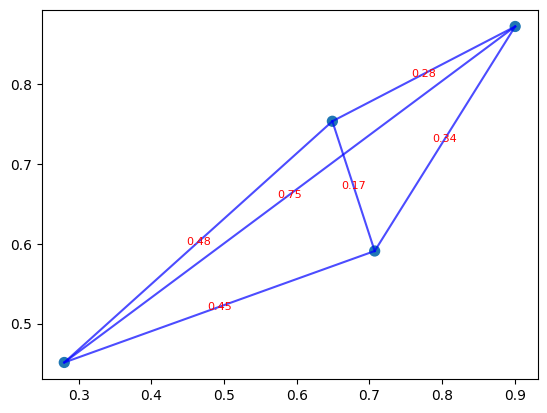

In [68]:
# This is just an example:
coords, W_np = get_graph_mat(n=4)
plot_graph(coords, W_np)
plt.show()

## Quantum Circuit

In [69]:
def graph_encoding_circuit(edges, num_qubits, reps, params, insert_barriers = True) -> QuantumCircuit:
    """
    Defines the graph encoding quantum circuit.
    :param edges: List of tuples of edges.
    :param num_qubits: Number of qubits.
    :param reps: Number of layers.
    :param params: Parameters symbols.
    :param insert_barriers: True if we want barriers in the quantum circuit.
    :return: The Quantum Circuit.
    """
    # Create a quantum circuit
    circuit = QuantumCircuit(num_qubits)

    # Apply Hadamard gates to all qubits
    circuit.h(range(num_qubits))

    for rep in range(reps):
        edge_w = params[rep][-1]

        # Edge encoding
        for edge_i, edge in enumerate(edges):
            circuit.cx(edge[0], edge[1])

            circuit.rz(edge_w[edge_i], edge[1])

            circuit.cx(edge[0], edge[1])

        # This barrier is just to improve visualization, it can be removed
        if insert_barriers: circuit.barrier()

        # Vertex encoding
        for q in range(num_qubits):
            circuit.rx(params[rep][q], q)

    return circuit

## Q - Model

In [70]:
class EquivariantLayer(nn.Module):
    def __init__(
            self,
            num_input_params : int,
            n_vars : int,
            n_edges : int,
            circuit_depth : int,
            params : list):
        """
        Initialize classical equivariant layer.
        :param num_input_params: Number of input parameters.
        :param n_vars: Number of variables.
        :param n_edges: Number of edges.
        :param circuit_depth: Depth of the circuit (repetitions).
        :param params: List of parameters.
        """
        super(EquivariantLayer, self).__init__()

        # Define weights for the Layer
        self.num_input_params = num_input_params * circuit_depth
        self.num_params = 2 * circuit_depth
        self.circuit_depth = circuit_depth

        param_init = torch.ones(1, self.num_params, dtype=torch.float32)
        self.params = torch.nn.Parameter(param_init)

        self.param_repeats = []
        for layer in range(self.circuit_depth):
            self.param_repeats.append(n_vars)
            self.param_repeats.append(n_edges)

        alphabetical_params = sorted(params)
        self.indices = [params.index(a) for a in alphabetical_params]

    def forward(self, inputs):
        """
        Forward execution of the layer.
        :param inputs: Input data.
        :return: Returns the expectation values.
        """
        repeated_params = self.params.repeat_interleave(torch.tensor(self.param_repeats))

        repeat_inputs = inputs.repeat(self.circuit_depth, 1)

        data_values = repeat_inputs * repeated_params
        output = data_values[:, self.indices]

        return output

In [71]:
class QModel(nn.Module):
    def __init__(self, n_input_params : int, n_vars : int, num_edges_in_graph : int, n_layers : int,
                 flattened_data_symbols : list, circuit : QuantumCircuit):
        """
        The neural network that will parameterize the function Q.
        
        :param n_input_params: Number of input parameters.
        :param n_vars: Number of variables in the Equivariant Layer.
        :param num_edges_in_graph: Number of edges in the graph.
        :param n_layers: Number of repetitions/layers.
        :param flattened_data_symbols: Flattened data symbols for the Equivariant Layer.
        :param circuit: The Equivariant Quantum Circuit.
        """
        super(QModel, self).__init__()
        self.n_input_params = n_input_params
        self.n_vars = n_vars
        self.num_edges_in_graph = num_edges_in_graph
        self.n_layers = n_layers
        self.flattened_data_symbols = flattened_data_symbols
        
        # Classical encoding layer.
        self.encoding_layer = EquivariantLayer(num_input_params=self.n_input_params, n_vars=self.n_vars, 
                                               n_edges=self.num_edges_in_graph, circuit_depth=self.n_layers, 
                                               params=self.flattened_data_symbols)
        
        # The Equivariant Quantum Circuit for Torch Connector.
        self.circuit = circuit

    def forward(self, input_data, observables) -> torch.Tensor:
        """
        Forward execution of the neural net.
        
        :param input_data: Input data.
        :return: Expectation values for all available nodes.
        """
        encoding_output = self.encoding_layer(input_data)
        qnn = TorchConnector(
            EstimatorQNN(
                circuit=self.circuit,
                input_params=self.circuit.parameters,
                observables=observables
            )
        )
        expectation_values = qnn(encoding_output)

        return expectation_values

In [72]:
from itertools import combinations

N_NODES = 4
N_LAYERS = 1

fully_connected_qubits = list(combinations(list(range(N_NODES)), 2))

def generate_eqc_model(fully_connected_qubits):
    """
    Generates the EQC model.
    :return: EQC model.
    """
    num_edges_in_graph = len(fully_connected_qubits)
    n_input_params = N_NODES + num_edges_in_graph

    data_symbols = []
    for layer in range(N_LAYERS):
        data = [Parameter(f'layer[{layer}]_v[{qubit}]') for qubit in range(N_NODES)]
        data += [[Parameter(f'layer[{layer}]_e[{ew}]') for ew in range(num_edges_in_graph)]]
        data_symbols.append(data)

    circuit = graph_encoding_circuit(fully_connected_qubits, N_NODES, N_LAYERS, data_symbols)

    flattened_data_symbols = []
    for layer in data_symbols:
        for item in layer:
            if type(item) == list:
                for symbol in item:
                    flattened_data_symbols.append(str(symbol))
            else:
                flattened_data_symbols.append(str(item))

    model = QModel(
        n_input_params=n_input_params, n_vars=N_NODES, 
        num_edges_in_graph=num_edges_in_graph, n_layers=N_LAYERS, 
        flattened_data_symbols=flattened_data_symbols, circuit=circuit,
    )

    return model

## Q-Learning

### Neural network wrapper

Below, we define the class QFunction, which will act as a wrapper around the neural net QNet, and can manipulate TSP (partial) solutions and translate them to tensors.

In [73]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
    
    def predict(self, state_tsr, observables):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr, observables)
        return estimated_rewards
                
    def get_best_action(self, state_tsr, observables):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated Q-Value
        """
        estimated_q_values = self.predict(state_tsr, observables=observables)  # size (nr_nodes,)
        return torch.argmax(estimated_q_values), torch.max(estimated_q_values)
        
    def batch_update(self, states_tsrs, observables_batch, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_q_vals = []
        for i in range(len(states_tsrs)):
            estimated_q_vals.append(self.model(states_tsrs[i], observables_batch[i]))
        estimated_q_vals = torch.stack(estimated_q_vals).squeeze(dim=1) # [range(len(actions)), actions]
        estimated_q_vals, _ = torch.max(estimated_q_vals, dim=1, keepdim=True)
        estimated_q_vals = estimated_q_vals.squeeze(dim=1)
        
        loss = self.loss_fn(estimated_q_vals, torch.tensor(targets, dtype=torch.float32, device=device))
        loss_val = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

### Experiences and memory definition

We'll now a tuple representing an experience, and the memory that contains such experiences. An experience is composed of a (state, action) tuple, and the corresponding "next state" and reward. The "next state" can be N step after the "state" in the case of N-step Q-learning. In experiences, we save states both in their tuple and tensor representations, in order to avoid computing these somewhat expensive translations after the experience has been stored.

In [74]:
from collections import namedtuple
import random

# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

### Utils

Below, we'll write a few more helper functions for computing solution length, deciding if a state is final and getting a next node at random from the graph.

In [75]:
def total_distance(tour, weight_mat):
    total_dist = 0
    
    for edge in tour:
        # Extract the node indices from the edge
        node1, node2 = edge
        
        # Retrieve the weight (distance) from the adjacency matrix
        dist = weight_mat[node1][node2]
        
        # Add the distance to the total
        total_dist += dist
    
    return total_dist

def graph_to_list(nodes: list, edge_weights: dict, available_nodes: list[int]) -> list[float]:
    """
    Convert a graph into a list.
    :param nodes: list of graph nodes.
    :param fully_connected_edges: list of tuples of edges.
    :param edge_weights: dictionary of edge weights.
    :param available_nodes: list of available nodes.
    :param node_to_qubit_map: dictionary to map nodes and qubits.
    :return: list of values from graph.
    """
    vals = []
    for node in nodes:
        n = int(node in available_nodes)
        vals.append(n * np.pi)

    for w in edge_weights:
        vals.append(np.arctan(w))

    return vals

def get_mask(nodes, weight_mat, available_nodes, partial_tour):
    mask = []
    for n in nodes:
        if n not in available_nodes:
            mask.append(0)
        elif n in available_nodes:
            mask.append(weight_mat[partial_tour[-1], n])
    return mask

def get_observables(partial_tour, available_nodes, weight_mat, nodes):
    observables = []
    last_edge = () if len(partial_tour) == 0 else partial_tour[-1]
    last_node = 0 if len(last_edge) == 0 else last_edge[1]
    
    for node in nodes:
        if node in available_nodes:
            observable = SparsePauliOp.from_sparse_list(
                [("ZZ", [last_node, node], weight_mat[last_node, node])],
                num_qubits=N_NODES
            )
            observables.append(observable)
        else:
            observable = SparsePauliOp.from_sparse_list(
                [("I", [0], -10000)],
                num_qubits=N_NODES
            )
            observables.append(observable)   
    return observables

### Training part

#### Hyperparameters

In [76]:
SEED = 1

# Graph generation
N_NODES = 7 # Number of nodes N

# Learning
N_EPISODES = 400
MEMORY_CAPACITY = 10000
N_STEP_QL = 2 # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 10

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5 # Learning rate decay.

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 0.005 # Epsilon decay.

FOLDER_NAME = './models'  # where to checkpoint the best models

#### Model Initialization

In [77]:
import os

def init_model(fully_connected_qubits, fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = generate_eqc_model(fully_connected_qubits)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

#### Training loop

In [78]:
import copy

State = namedtuple('State', ('weight_mat', 'state_list', 'is_final', 'partial_tour', 'available_nodes'))

# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
algorithm_globals.random_seed = SEED

# Create module, optimizer, LR scheduler, and Q-function
fully_connected_qubits = list(combinations(list(range(N_NODES)), 2))
Q_func, Q_net, optimizer, lr_scheduler = init_model(fully_connected_qubits)

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(N_EPISODES):
    # Sample a new random graph
    nodes = range(0, N_NODES)
    coords, weight_mat = get_graph_mat(n=N_NODES)
    weight_mat_tsr = torch.tensor(weight_mat, dtype=torch.float32, requires_grad=False, device=device)
    
    # current partial solution - a list of node index
    partial_tour = []
    initial_node = 0
    available_nodes = list(range(1, N_NODES))
    
    # current state (tuple and tensor)
    edge_weights = []
    for q in fully_connected_qubits:
        edge_weights.append(weight_mat[q[0], q[1]])
    current_state = graph_to_list(
        nodes=nodes,
        edge_weights=edge_weights,
        available_nodes=available_nodes
    )
    current_state = State(weight_mat=weight_mat,state_list=current_state, is_final=len(available_nodes) == 0, partial_tour=partial_tour, available_nodes=copy.copy(available_nodes))
    current_state_tsr = torch.tensor(current_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)
    
    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1
    while len(available_nodes) > 0:
        t += 1 # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = random.choice(available_nodes)
            nr_explores += 1
        else:
            # exploit
            observables = get_observables(
                partial_tour=partial_tour,
                available_nodes=available_nodes,
                weight_mat=weight_mat,
                nodes=nodes
            )
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, observables)
        
        if partial_tour:
            last_element = partial_tour[-1][-1]
        else:
            last_element = 0
        next_solution = partial_tour + [(last_element, next_node)]
        
        # reward observed for taking this step
        reward = -weight_mat[last_element, next_node]
        
        available_nodes.remove(next_node)
        next_state = graph_to_list(
            nodes=nodes,
            edge_weights=edge_weights,
            available_nodes=available_nodes
        )
        next_state = State(
            weight_mat=weight_mat,
            state_list=next_state,
            is_final=len(available_nodes) == 0,
            partial_tour=next_solution,
            available_nodes=copy.copy(available_nodes)
        )
        next_state_tsr = torch.tensor(next_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-Learning:
        if len(partial_tour) + 1 >= N_STEP_QL:
            memory.remember(Experience(
                state=states[-N_STEP_QL],
                state_tsr=states_tsrs[-N_STEP_QL],
                action=actions[-N_STEP_QL],
                reward=sum(rewards[-N_STEP_QL:]),
                next_state=next_state,
                next_state_tsr=next_state_tsr
            ))
            
        if len(available_nodes) == 0:
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(
                    state=states[-n],
                    state_tsr=states_tsrs[-n], 
                    action=actions[-n], 
                    reward=sum(rewards[-n:]), 
                    next_state=next_state,
                    next_state_tsr=next_state_tsr
                ))
        
        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        partial_tour = next_solution
        
        # Take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 100:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_weight_mats = [e.state.weight_mat for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            batch_observables = []
            
            for i, experience in enumerate(experiences):
                observables = get_observables(
                    experience.state.partial_tour,
                    available_nodes=experience.state.available_nodes,
                    weight_mat=experience.state.weight_mat,
                    nodes=nodes
                )
                target = experience.reward
                if not experience.next_state.is_final:
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr, 
                                                            get_observables(
                                                                experience.next_state.partial_tour,
                                                                available_nodes=experience.next_state.available_nodes,
                                                                weight_mat=experience.next_state.weight_mat,
                                                                nodes=nodes
                                                            ))
                    target += GAMMA * best_reward
                batch_targets.append(target)
                batch_observables.append(observables)
            
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_observables, batch_actions, batch_targets)
            losses.append(loss)
            
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)

    # Calculate total distance of tour and add it to path_lengths.
    length = total_distance(partial_tour, weight_mat)
    path_lengths.append(length)
    
    # Print information from episode.
    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (weight_mat, coords, [edge for edge in partial_tour])

Ep 0. Loss = -1.000 / median length = 2.777 / last = 2.7766 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 3.135 / last = 2.6171 / epsilon = 0.9511 / lr = 0.0050
Ep 20. Loss = 29996448.000 / median length = 3.031 / last = 2.1691 / epsilon = 0.9046 / lr = 0.0050
Ep 30. Loss = 19997608.000 / median length = 3.050 / last = 1.8544 / epsilon = 0.8604 / lr = 0.0050
Ep 40. Loss = 19998410.000 / median length = 3.031 / last = 2.7655 / epsilon = 0.8183 / lr = 0.0050
Ep 50. Loss = 19998660.000 / median length = 3.010 / last = 2.0552 / epsilon = 0.7783 / lr = 0.0050
Ep 60. Loss = 9998672.000 / median length = 2.771 / last = 2.2675 / epsilon = 0.7403 / lr = 0.0050
Ep 70. Loss = 9999321.000 / median length = 2.822 / last = 3.0674 / epsilon = 0.7041 / lr = 0.0050
Ep 80. Loss = 29997664.000 / median length = 2.633 / last = 2.3603 / epsilon = 0.6696 / lr = 0.0050
Ep 90. Loss = 39996096.000 / median length = 2.514 / last = 1.8945 / epsilon = 0.6369 / lr = 0.0050
Ep 100. Loss = 

#### Inspect Training Metrics

Let's look at the (moving averages of) loss and path length over training.

Text(0.5, 0, 'episode')

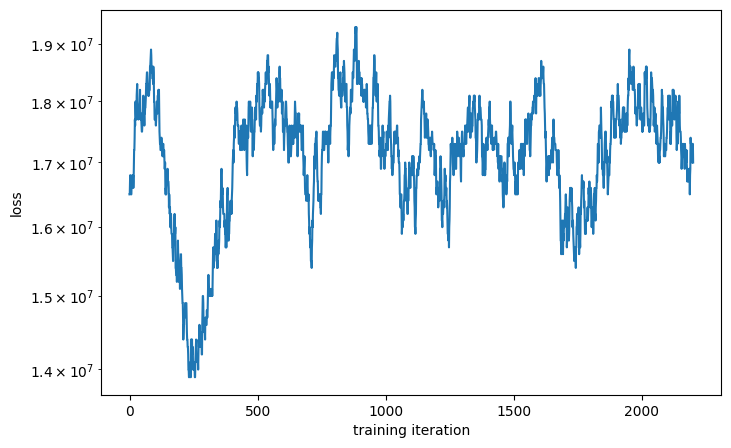

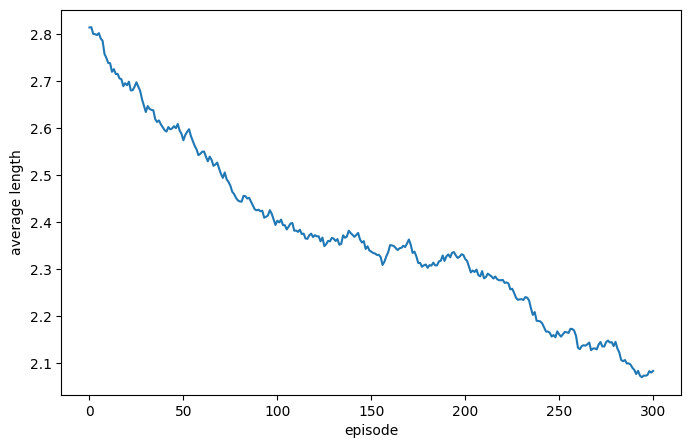

In [79]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(path_lengths, 100))
plt.ylabel('average length')
plt.xlabel('episode')

#### Re-run Best Model and Look at Paths

In [81]:
""" Get file with smallest distance
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

""" Load checkpoint
"""
fully_connected_qubits = list(combinations(list(range(N_NODES)), 2))
Q_func, Q_net, optimizer, lr_scheduler = init_model(fully_connected_qubits, os.path.join(FOLDER_NAME, shortest_fname))

""" Generate example solutions
"""
NR_NODES = 7
for sample in range(10):
    coords, weight_mat = get_graph_mat(n=NR_NODES)
    W = torch.tensor(weight_mat, dtype=torch.float32, requires_grad=False, device=device)
    
    partial_tour = []
    initial_node = 0
    available_nodes = list(range(1, N_NODES))
    nodes = range(0, N_NODES)
    
    # current state (tuple and tensor)
    edge_weights = []
    for q in fully_connected_qubits:
        edge_weights.append(weight_mat[q[0], q[1]])
    current_state = graph_to_list(
        nodes=nodes,
        edge_weights=edge_weights,
        available_nodes=available_nodes
    )
    current_state = State(weight_mat=weight_mat,state_list=current_state, is_final=len(available_nodes) == 0, partial_tour=partial_tour, available_nodes=copy.copy(available_nodes))
    current_state_tsr = torch.tensor(current_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)
    
    while len(available_nodes) > 0:
        observables = get_observables(
                partial_tour=partial_tour,
                available_nodes=available_nodes,
                weight_mat=weight_mat,
                nodes=nodes
            )
        next_node, est_reward = Q_func.get_best_action(current_state_tsr, observables)
        
        available_nodes.remove(next_node)
        
        if partial_tour:
            last_element = partial_tour[-1][-1]
        else:
            last_element = 0
        partial_tour = partial_tour + [(last_element, next_node)]
        
        current_state = graph_to_list(
            nodes=nodes,
            edge_weights=edge_weights,
            available_nodes=available_nodes
        )
        current_state = State(weight_mat=weight_mat,state_list=current_state, is_final=len(available_nodes) == 0, partial_tour=partial_tour, available_nodes=copy.copy(available_nodes))
        current_state_tsr = torch.tensor(current_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)
        
    print(weight_mat)
    print(partial_tour)

shortest avg length found: 1.167163770760748
[[0.         0.52246006 0.13029417 0.62960431 0.2317975  0.26365508
  0.68985026]
 [0.52246006 0.         0.58806909 0.96570882 0.29315897 0.28317808
  1.0433973 ]
 [0.13029417 0.58806909 0.         0.72356373 0.29886107 0.36401525
  0.77630578]
 [0.62960431 0.96570882 0.72356373 0.         0.77169625 0.70660859
  0.0797315 ]
 [0.2317975  0.29315897 0.29886107 0.77169625 0.         0.10803697
  0.84283868]
 [0.26365508 0.28317808 0.36401525 0.70660859 0.10803697 0.
  0.7813609 ]
 [0.68985026 1.0433973  0.77630578 0.0797315  0.84283868 0.7813609
  0.        ]]
[(0, tensor(2)), (tensor(2), tensor(4)), (tensor(4), tensor(5)), (tensor(5), tensor(1)), (tensor(1), tensor(6)), (tensor(6), tensor(3))]
[[0.         0.47593006 0.52778262 0.75864784 0.16302832 0.29757524
  0.73433018]
 [0.47593006 0.         0.18332933 0.36169562 0.49259873 0.18093722
  0.31957415]
 [0.52778262 0.18332933 0.         0.50750118 0.48473421 0.25400722
  0.45961202]
 [0.75